# Regression Trees

In this notebook, we will train and tune a regression tree on the `Concrete` dataset. We will be using the `DecisionTreeRegressor` class from the `sklearn.tree` module.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")
crt.head()

,Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


For trees, we are not required to standardize either the predictors or the response. 

In [4]:
# extract predictors and response - standardization makes no difference
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
y = crt['Strength'].values

# extract feature names to be used later in visualizations
feature_names = crt.drop('Strength',axis=1).columns.tolist()

In [5]:
feature_names

['Cement', 'Slag', 'FlyAsh', 'Water', 'SPlast', 'CAgg', 'FAgg', 'Age']

`DecisionTreeRegressor` does not have the full functionality of `rpart`. This partly due to the data storage format used by scikit-learn - NumPy arrays or SciPy sparse matrices. These data structures allow only a single data type. In particular,

1. It cannot handle categorical predictors directly. We need to explictly one-hot encode categorical variables before training the model.
2. It cannot handle missing values. The missing values need to be imputed before training the model.


In [6]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(
    min_samples_leaf=5, # equivalent to minbucket in rpart
    ccp_alpha=1e-4, # cost complexity parameter
)

The preferred strategy of fitting a tree is 
1. First grow a large tree, i.e., until any subsequent split results in leaves with with less than `min_samples_leaf` observations.
2. Prune the tree back to be optimal with respect to the cost-complexity parameter `ccp_alpha`, if it is greather than 0.

**Cost complextiy criterion:**
$$
R_\alpha(T) = R(T) + \alpha|T|,
$$

where $R(\cdot)$ is some measure of impurity (for e.g., mean squared error for regression) in the tree.


The `.fit` method runs both operations.

In [7]:
# fit tree 
# grows a large tree and prunes it back to match ccp_alpha 1e-4
_ = reg_tree.fit(X,y)

## Selecting `ccp_alpha` via CV 

Steps involved in selecting alpha:

1. Extract the cost-complexity pruning path for the tree using the `.cost_complexity_pruning_path` method.
2. Perform cross-validation to find the performance of each `ccp_alpha` in the path.
3. Select `ccp_alpha` using either the best CV loss rule or the one standard error rule. 


### Weakest link pruning


Weakest link or minimum cost complexity pruning recursively finds the node with the “weakest link” - i.e., the split which resulted in the least decrease in impurity. The weakest link is characterized by an effective alpha, for which it greats pruned. With larger values of alpha, more of the tree is pruned, which increases the total impurity of its leaves. 

In the `.cost_complexity_pruning_path` method, weakest link pruning is run until only one node is left in the tree. The method returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.

In [8]:
# compute the cost-complexity pruning path for the tree
ccp_path = reg_tree.cost_complexity_pruning_path(X,y)

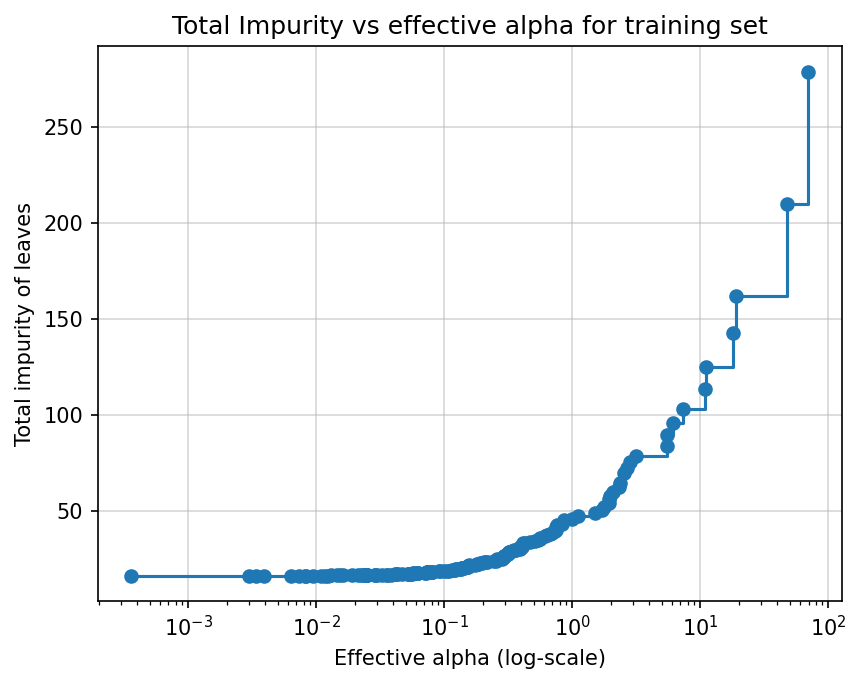

In [9]:
ccp_alphas, impurities = ccp_path.ccp_alphas[1:], ccp_path.impurities[1:]

# plot of impurities vs ccp_alpha
fig, ax = plt.subplots()
_ = ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
_ = ax.set_xlabel("Effective alpha (log-scale)")
_ = ax.set_ylabel("Total impurity of leaves")
_ = ax.set_title("Total Impurity vs effective alpha for training set")
_ = ax.semilogx()
_ = ax.grid(alpha=0.5)

In [10]:
# impurity with one node - mean squared error
np.mean((y-y.mean())**2)

278.81086128004523

### Cross-validation

For each fold in the cross-validation loop, we successively try increasing values of $\alpha$. The (large) initial tree needs to be grown only once. 

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [12]:
np.random.seed(1234)
kf = KFold(n_splits=5,shuffle=True) # equivalent to using xval=5 in rpart.control
mses = np.empty((kf.n_splits,ccp_alphas.shape[0]))

for i,(train_index,test_index) in enumerate(kf.split(X)):
    
    # initialize tree for this fold and fit large tree
    tree_fold = DecisionTreeRegressor(min_samples_leaf=5).fit(X[train_index,:],y[train_index])
    
    for j,alpha in enumerate(ccp_alphas):
        # update the value of alpha
        tree_fold.set_params(**{'ccp_alpha':alpha})
        
        # prune the tree further
        _ = tree_fold._prune_tree()
        
        # compute predictions and evaluate on test set 
        y_pred_test = tree_fold.predict(X[test_index,:])
        mses[i,j] = mean_squared_error(y[test_index],y_pred_test)

In [13]:
# CV estimates
mse_cv = mses.mean(axis=0)
r2_cv = 1-mse_cv/y.var()

In [14]:
#  maximum r2
idx_r2max = r2_cv.argmax()

print('Best R^2...: %.3f'%(r2_cv[idx_r2max]))

Best R^2...: 0.809


In the lectures, we dicussed two rules in picking the value of alpha: 

1. Best CV metric (usual): Pick the alpha with the best loss $1-R_{CV}^2$ (using the convention in rpart). Denote this loss by $1-R_{CV,best}^2$. 
2. 1 SE rule: Pick the **largest** value of alpha whose $1-R_{CV}^2$ is either equal to or less than $(1-R_{CV,best}^2)$ + $SE(1-R_{CV,best}^2)$.


The 1 SE rule results in a more conservative tree, but it might generalize better - remember that trees can easily overfit. This rule is best used for smaller datasets.

**Estimating standard error for CV estimates:**

Let $\mathrm{CV}^{(i)}, i=1,\ldots K$ denote the cross-validation losses for folds $i=1,\ldots,K$. Let $\mathrm{CV}_\mathrm{est}$ denote the average cross-validation estimate. So, we have

$$
\mathrm{CV}_\mathrm{est} = \frac{1}{K} \sum_{i=1}^{K} \mathrm{CV}^{(i)}.
$$

Standard error for the CV fold losses $\mathrm{CV}^{(i)}$ can be computed using `np.std` or the `.std` method of an array, and let's denote it by $\hat{S}_\mathrm{CV}$. 

We are, however, more interested in the standard error of the final averaged estimate $\mathrm{CV}_\mathrm{est}$. This is obtained as follows:
$$
\mathrm{SE}\left(\mathrm{CV}_\mathrm{est}\right) = \frac{1}{\sqrt{K}} \hat{S}_\mathrm{CV}.
$$

In [15]:
# SE for CV estimate = (SE for folds)/sqrt(num.folds)
mse_se_cv = mses.std(axis=0)/np.sqrt(mses.shape[0])
r2_se_cv = mse_se_cv/y.var() # scaling the SE by the variance

In [16]:
# rule 2 - 1SE rule
r2_1se_max = r2_cv[idx_r2max] - r2_se_cv[idx_r2max]
idx_1se = np.argmax(r2_cv<=r2_1se_max)-1

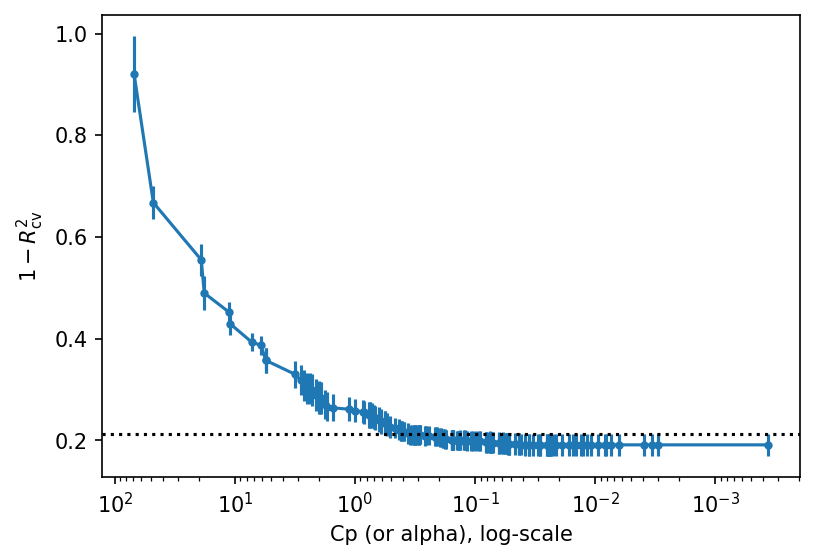

In [17]:
# reproducing plotcp output 
fig,ax = plt.subplots(1,1,figsize=(6,4))
_= ax.errorbar(ccp_alphas,1-r2_cv,yerr=r2_se_cv,marker='.')
_ = ax.axhline(y=1-r2_1se_max,linestyle='dotted',color='k',zorder=10)
_ = ax.invert_xaxis() # reverse orders of Cps
_ = ax.semilogx() # plot on log scale
_ = ax.set_xlabel('Cp (or alpha), log-scale')
_ = ax.set_ylabel(r'$1-R^{2}_\mathrm{cv}$')

In [18]:
# R2 values
print('alpha with max R^2 rule...: %5.4f'%ccp_alphas[idx_r2max])
print('alpha with one SE rule....: %5.4f'%ccp_alphas[idx_1se])

alpha with max R^2 rule...: 0.0286
alpha with one SE rule....: 0.3491


In [19]:
# R2 values
print('5-fold CV with max R^2 rule...: %5.3f'%r2_cv[idx_r2max])
print('5-fold CV with one SE rule....: %5.3f'%r2_cv[idx_1se])

5-fold CV with max R^2 rule...: 0.809
5-fold CV with one SE rule....: 0.789


## Final decision tree

In [20]:
# prune back initial tree with the best CV accuracy
reg_tree.set_params(ccp_alpha=ccp_alphas[idx_r2max])
reg_tree._prune_tree()

### Comparison with different models

In week 3, we compared the neural network and linear regression models using 5 replicates of 5 fold CV. 

```
CV R2 for neural network.....: 0.914
CV R2 for linear regression..: 0.605
```

We will perform 5 replicates of 5 fold CV to compare the tree model with these two models.

In [21]:
from sklearn.model_selection import RepeatedKFold

np.random.seed(1234)

# 5-replicates of 5-fold CV
n_repeats=5
n_folds = 5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses = np.empty(n_folds*n_repeats)

for i,(train_index,test_index) in enumerate(rkf.split(X)):
    tree_fold = DecisionTreeRegressor(min_samples_leaf=5,ccp_alpha=ccp_alphas[idx_r2max])
    _ = tree_fold.fit(X[train_index,:],y[train_index])

    # compute predictions and evaluate on test set 
    y_pred_test = tree_fold.predict(X[test_index,:])
    mses[i] = mean_squared_error(y[test_index],y_pred_test)
    
    
mse_tree_cv = mses.mean()
r2_tree_cv = 1-mse_tree_cv/y.var()
print('CV R2 for regression tree....: %5.3f'%r2_tree_cv)

CV R2 for regression tree....: 0.817


## Visualizations

In [22]:
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [23]:
print(export_text(reg_tree,feature_names=feature_names))

|--- Age <= 21.00
|   |--- Cement <= 354.50
|   |   |--- Age <= 10.50
|   |   |   |--- Cement <= 255.25
|   |   |   |   |--- Cement <= 155.00
|   |   |   |   |   |--- Age <= 5.00
|   |   |   |   |   |   |--- value: [5.13]
|   |   |   |   |   |--- Age >  5.00
|   |   |   |   |   |   |--- value: [10.04]
|   |   |   |   |--- Cement >  155.00
|   |   |   |   |   |--- SPlast <= 11.80
|   |   |   |   |   |   |--- FAgg <= 690.95
|   |   |   |   |   |   |   |--- value: [20.75]
|   |   |   |   |   |   |--- FAgg >  690.95
|   |   |   |   |   |   |   |--- FlyAsh <= 169.70
|   |   |   |   |   |   |   |   |--- FAgg <= 749.55
|   |   |   |   |   |   |   |   |   |--- FAgg <= 745.45
|   |   |   |   |   |   |   |   |   |   |--- Cement <= 186.95
|   |   |   |   |   |   |   |   |   |   |   |--- value: [11.07]
|   |   |   |   |   |   |   |   |   |   |--- Cement >  186.95
|   |   |   |   |   |   |   |   |   |   |   |--- value: [15.62]
|   |   |   |   |   |   |   |   |   |--- FAgg >  745.45
|   |   |   |   

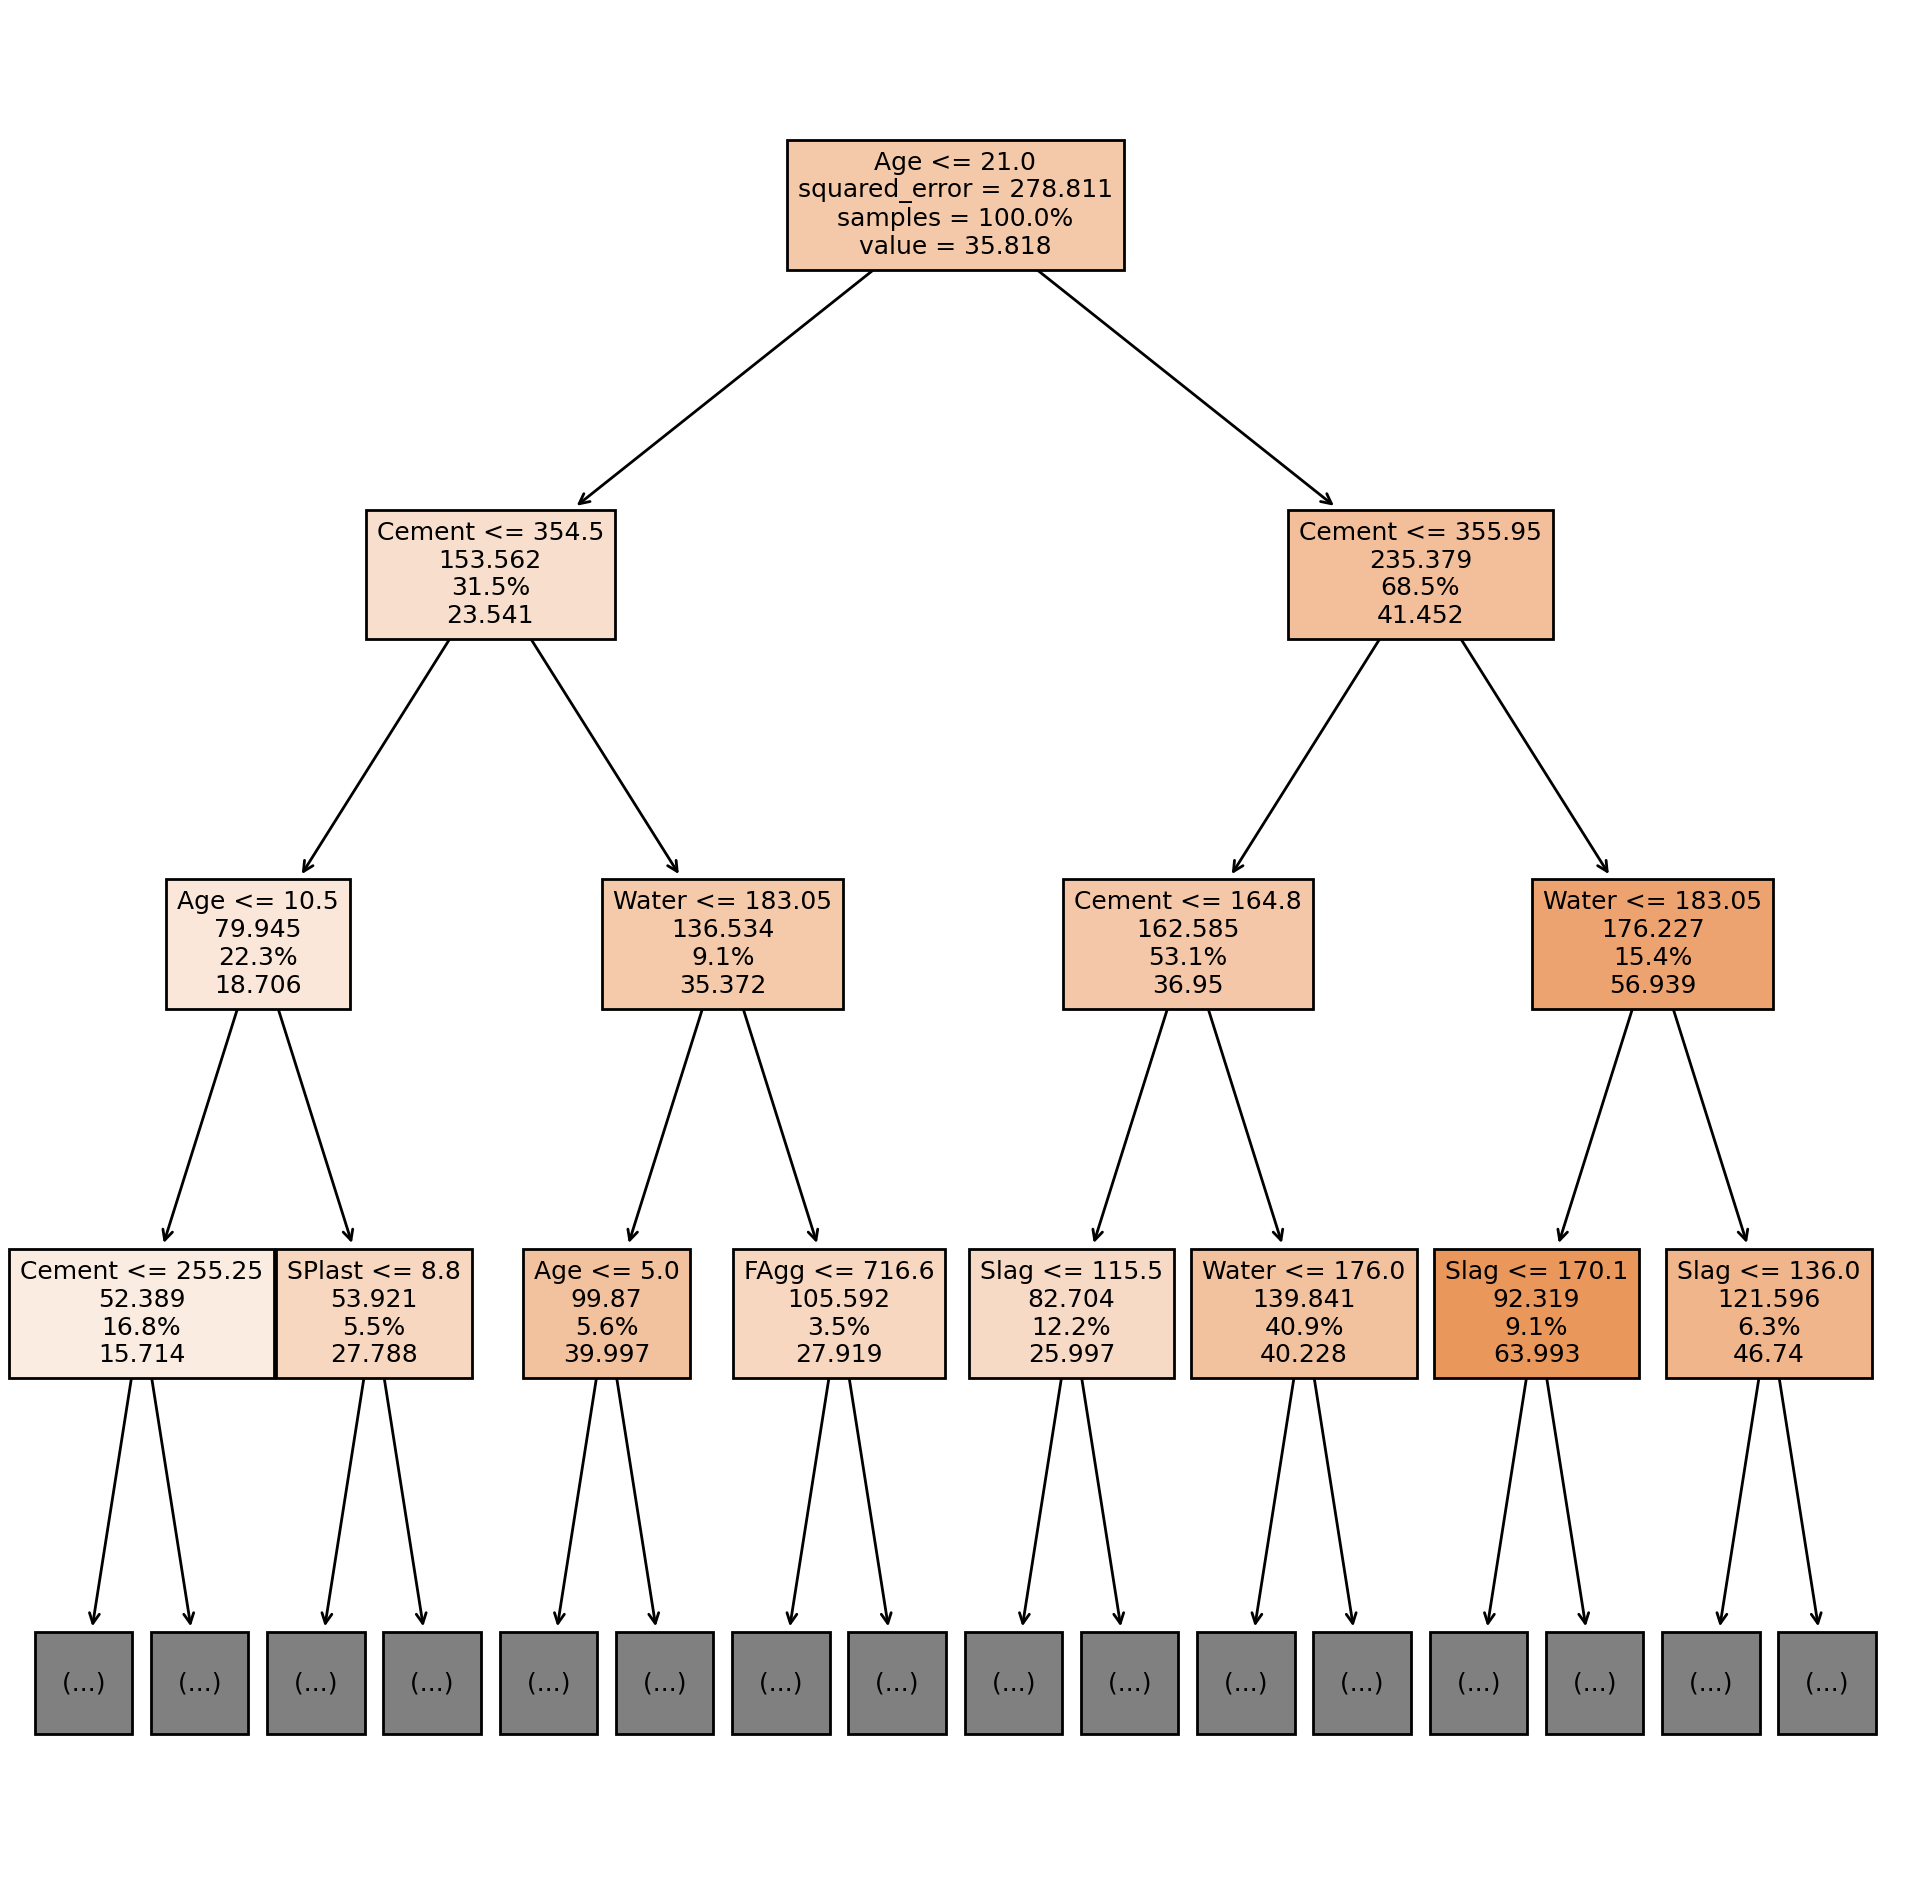

In [24]:
# visualize tree
fig = plt.figure(figsize=(12,12),dpi=200)
_ = plot_tree(
    reg_tree,
    feature_names=crt.drop('Strength',axis=1).columns,
    max_depth=3,
    label='root',
    fontsize=9,
    proportion=True,
    filled=True 
)

## Feature importance

In [25]:
# (normalized) total reduction in SSE
reg_tree.feature_importances_

array([0.37873164, 0.1086545 , 0.00894777, 0.11009876, 0.02063523,
       0.02083282, 0.02007301, 0.33202626])

In [26]:
feat_imp = pd.Series(reg_tree.feature_importances_,index=feature_names).sort_values(ascending=False)
feat_imp.round(3)

Cement    0.379
Age       0.332
Water     0.110
Slag      0.109
CAgg      0.021
SPlast    0.021
FAgg      0.020
FlyAsh    0.009
dtype: float64

<AxesSubplot: >

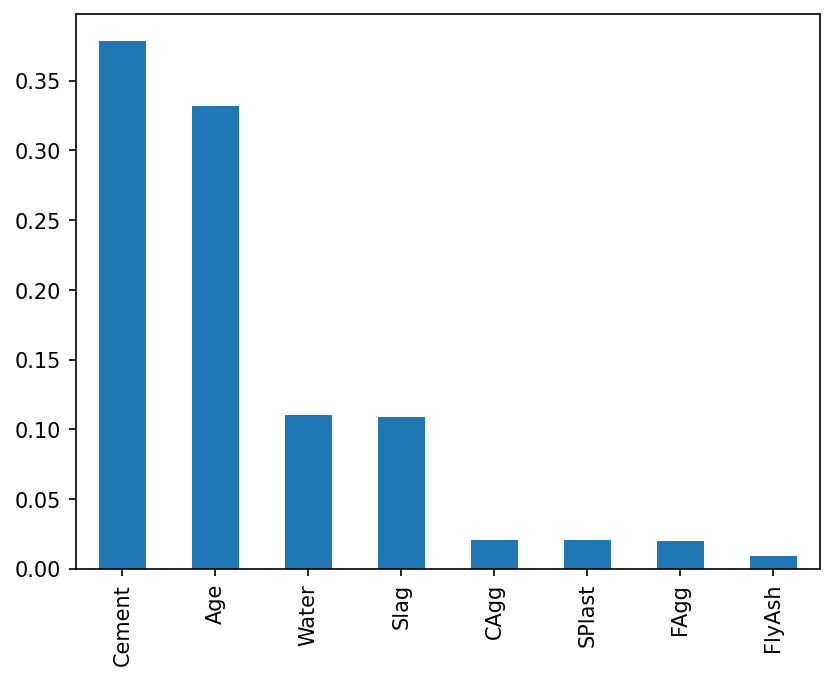

In [27]:
# plot the importance values
feat_imp.plot.bar()